#### Import Libraries

Need some more work on it. will be using model.py and utils.py from local for now

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
import subprocess
!pip install torchinfo

# Define the repository details
repo_name = "ERA_v2"
git_repo_url = "https://github.com/Gishnumohan/ERA_v2.git"
branch_name = "main"
folder_name = "Assignment10"

# Clone the repository and checkout the specified branch
subprocess.run(f"rm -rf {repo_name}", shell=True)
subprocess.run(f"git clone {git_repo_url}", shell=True)
subprocess.run(f"cd {repo_name} && git checkout {branch_name} && cd {folder_name}", shell=True)

# Add the cloned repository to Python path
sys.path.append(f"/content/{repo_name}/{folder_name}")



# Import user-defined modules
from modules.model import CustomResNet
from modules.utils import *


Mounted at /content/drive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchinfo
!pip install torch-lr-finder
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

import matplotlib.pyplot as plt
import numpy as np

"""
#from utils import *
%run utils.py         #to run every update in utils.py till code complition

#from model import Net
%run model.py
"""

!pip install torchsummary #Installs torch summary, if not available
from torchsummary import summary

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# cutout needs to be half of the image size
cutout_size = 16

# Train Phase Transformations
train_transforms = A.Compose(
    A.Compose([
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
        A.CoarseDropout( max_holes=1, max_height=cutout_size, max_width=cutout_size,
                        min_holes=1, min_height=cutout_size, min_width=cutout_size,
                        fill_value=[0.4915, 0.4823, 0.4468], mask_fill_value=None),
        A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
        ToTensorV2(),
    ])
)

# Test Phase Transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
    ToTensorV2(),
])

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:53: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  warnings.warn(


In [4]:
import cv2
import os
import copy
from torch.utils.data import Dataset
from torchvision import datasets

class CIFAR10_Transforms(Dataset):
    def __init__(self, dataset, transforms):
        self.transforms = transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        # Get the image and label from the dataset
        image, label = self.dataset[idx]

        # Apply transformations on the image
        image = self.transforms(image=np.array(image))["image"]

        return image, label

    def __len__(self):
        return len(self.dataset)



#### Dataset and Creating Train/Test Split

In [5]:
train_data = datasets.CIFAR10('../data', train=True, download=True)
test_data = datasets.CIFAR10('../data', train=False, download=True)

train_data = CIFAR10_Transforms(train_data, train_transforms)
test_data = CIFAR10_Transforms(test_data, test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 43059703.38it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


#### Dataloader Arguments & Test/Train Dataloaders

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
from torchsummary import summary
device = setDevice()
model = CustomResNet().to(device)
summary(model, input_size=(3,32, 32))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14       

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Optimizer and Loss Function

In [9]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
PREFERRED_START_LR = 0.3
PREFERRED_WEIGHT_DECAY = 0

optimizer = optim.Adam(
    model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY
)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

Find Learning Rate

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.22E-02


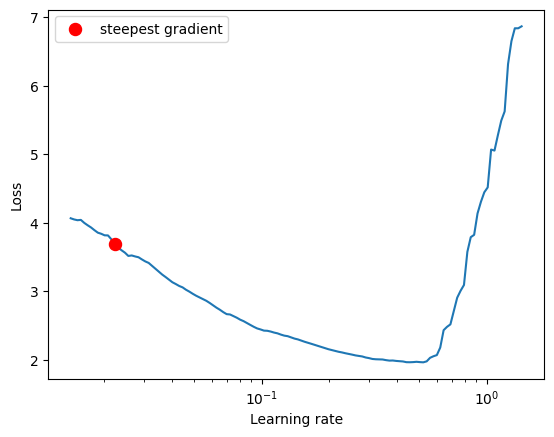

0.02221946860939524


In [10]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes
# https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=train_loader, end_lr=10, num_iter=200, start_lr=1e-2)
# https://github.com/davidtvs/pytorch-lr-finder/issues/88
plot, suggested_lr = lr_finder.plot(suggest_lr=True)
lr_finder.reset()
plot.figure.savefig("LRFinder - Suggested Max LR.png")
print(suggested_lr)

In [11]:
print(f"Suggested Max LR: {suggested_lr}")

NUM_EPOCHS  = 24

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=5,
    three_phase=False,
    final_div_factor=20,
    verbose=False,
)

Suggested Max LR: 0.02221946860939524


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [12]:
for epoch in range(NUM_EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.775978446006775 Batch_id=97 Accuracy=22.16: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]



Test set: Average loss: 1.8040, Accuracy: 3308/10000 (33.08%)

EPOCH: 1


Loss=1.5602322816848755 Batch_id=97 Accuracy=40.20: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 1.3657, Accuracy: 4911/10000 (49.11%)

EPOCH: 2


Loss=1.2937285900115967 Batch_id=97 Accuracy=51.23: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 1.1539, Accuracy: 5788/10000 (57.88%)

EPOCH: 3


Loss=1.0238431692123413 Batch_id=97 Accuracy=59.20: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.9420, Accuracy: 6682/10000 (66.82%)

EPOCH: 4


Loss=0.8211392164230347 Batch_id=97 Accuracy=64.39: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.8171, Accuracy: 7109/10000 (71.09%)

EPOCH: 5


Loss=0.8358722925186157 Batch_id=97 Accuracy=69.64: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.6769, Accuracy: 7664/10000 (76.64%)

EPOCH: 6


Loss=0.7616837620735168 Batch_id=97 Accuracy=72.63: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.6264, Accuracy: 7784/10000 (77.84%)

EPOCH: 7


Loss=0.6594778895378113 Batch_id=97 Accuracy=75.52: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.5831, Accuracy: 8042/10000 (80.42%)

EPOCH: 8


Loss=0.5901183485984802 Batch_id=97 Accuracy=76.74: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.5605, Accuracy: 8134/10000 (81.34%)

EPOCH: 9


Loss=0.6841498613357544 Batch_id=97 Accuracy=78.01: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.5222, Accuracy: 8290/10000 (82.90%)

EPOCH: 10


Loss=0.6081541776657104 Batch_id=97 Accuracy=79.54: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.5119, Accuracy: 8299/10000 (82.99%)

EPOCH: 11


Loss=0.45530858635902405 Batch_id=97 Accuracy=80.89: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.4383, Accuracy: 8537/10000 (85.37%)

EPOCH: 12


Loss=0.4837803542613983 Batch_id=97 Accuracy=81.20: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.5227, Accuracy: 8312/10000 (83.12%)

EPOCH: 13


Loss=0.4911394715309143 Batch_id=97 Accuracy=82.43: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.4109, Accuracy: 8628/10000 (86.28%)

EPOCH: 14


Loss=0.4641658365726471 Batch_id=97 Accuracy=83.85: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.4048, Accuracy: 8669/10000 (86.69%)

EPOCH: 15


Loss=0.5466334223747253 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4287, Accuracy: 8569/10000 (85.69%)

EPOCH: 16


Loss=0.32745030522346497 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.3847, Accuracy: 8774/10000 (87.74%)

EPOCH: 17


Loss=0.49733760952949524 Batch_id=97 Accuracy=85.13: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.3677, Accuracy: 8832/10000 (88.32%)

EPOCH: 18


Loss=0.46643272042274475 Batch_id=97 Accuracy=85.91: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.3714, Accuracy: 8780/10000 (87.80%)

EPOCH: 19


Loss=0.34201398491859436 Batch_id=97 Accuracy=86.41: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.3889, Accuracy: 8765/10000 (87.65%)

EPOCH: 20


Loss=0.39911019802093506 Batch_id=97 Accuracy=87.14: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.4019, Accuracy: 8759/10000 (87.59%)

EPOCH: 21


Loss=0.3341626524925232 Batch_id=97 Accuracy=87.79: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.3446, Accuracy: 8892/10000 (88.92%)

EPOCH: 22


Loss=0.38810762763023376 Batch_id=97 Accuracy=87.69: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 0.3583, Accuracy: 8893/10000 (88.93%)

EPOCH: 23


Loss=0.302778035402298 Batch_id=97 Accuracy=88.46: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.3396, Accuracy: 8909/10000 (89.09%)

